<module 'matplotlib.pyplot' from 'c:\\Users\\Marcus\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

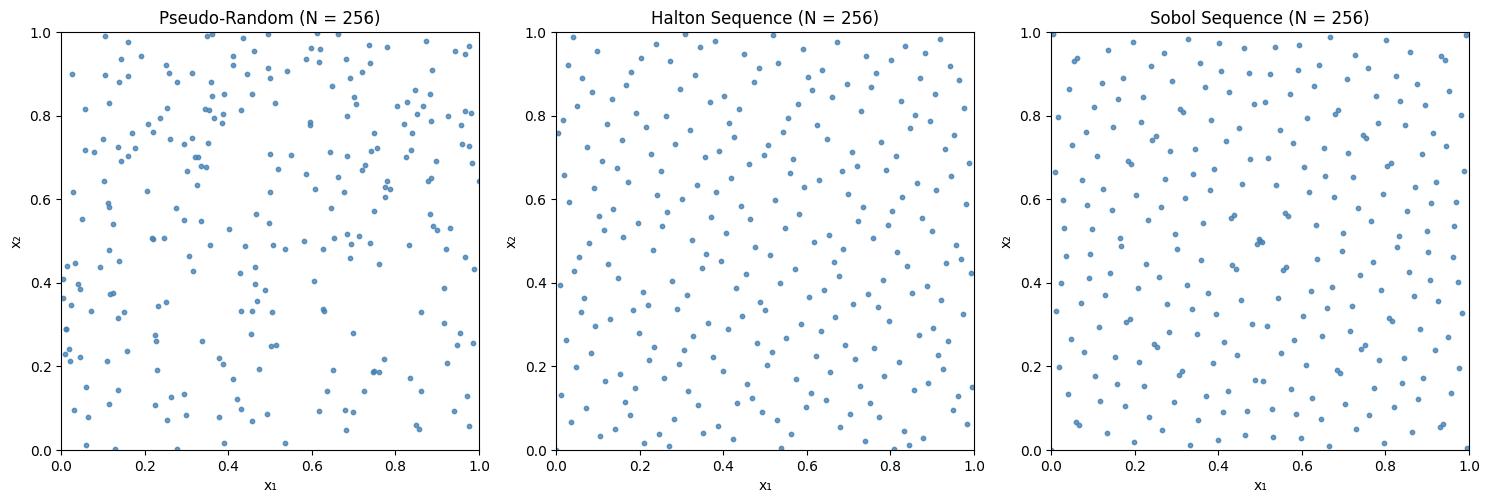

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

# Parameters
n_samples = 256
dim = 2

# Generate samples
np_random = np.random.rand(n_samples, dim)

halton = qmc.Halton(d=dim, scramble=False)
halton_sample = halton.random(n=n_samples)

sobol = qmc.Sobol(d=dim, scramble=False)
sobol_sample = sobol.random_base2(m=8)  # 2^8 = 256

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

titles = [
    "Pseudo-Random (N = 256)",
    "Halton Sequence (N = 256)",
    "Sobol Sequence (N = 256)"
]

samples = [np_random, halton_sample, sobol_sample]

for i, (ax, sample) in enumerate(zip(axs, samples)):
    ax.scatter(*sample.T, s=10, color="steelblue", alpha=0.8)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.set_title(titles[i])

plt.tight_layout()
plt


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

np.random.seed(42)  # reproducability 


true_value = np.exp(1) - 1
sample_sizes = [2**i for i in range(3, 13)]  # N = 8 to 4096

mc_errors = []
qmc_errors = []
mc_estimates = []
qmc_estimates = []

# Header for the table
print(f"{'N':>6} | {'MC Estimate':>12} | {'QMC Estimate':>12} | {'MC Error':>10} | {'QMC Error':>10}")
print("-" * 65)

for N in sample_sizes:
    # Monte Carlo
    x_mc = np.random.rand(N)
    mc_est = np.mean(np.exp(x_mc))
    mc_err = abs(mc_est - true_value)
    mc_estimates.append(mc_est)
    mc_errors.append(mc_err)

    # Quasi-Monte Carlo (Sobol)
    sobol_engine = qmc.Sobol(d=1, scramble=False)
    x_qmc = sobol_engine.random_base2(m=int(np.log2(N)))
    qmc_est = np.mean(np.exp(x_qmc))
    qmc_err = abs(qmc_est - true_value)
    qmc_estimates.append(qmc_est)
    qmc_errors.append(qmc_err)

    # Print table row
    print(f"{N:6} | {mc_est:12.6f} | {qmc_est:12.6f} | {mc_err:10.6f} | {qmc_err:10.6f}")



     N |  MC Estimate | QMC Estimate |   MC Error |  QMC Error
-----------------------------------------------------------------
     8 |     1.714506 |     1.613126 |   0.003776 |   0.105156
    16 |     1.571763 |     1.665145 |   0.146519 |   0.053137
    32 |     1.771995 |     1.691574 |   0.053713 |   0.026708
    64 |     1.663822 |     1.704893 |   0.054460 |   0.013389
   128 |     1.715008 |     1.711579 |   0.003274 |   0.006703
   256 |     1.742072 |     1.714928 |   0.023790 |   0.003354
   512 |     1.693072 |     1.716604 |   0.025210 |   0.001677
  1024 |     1.725352 |     1.717443 |   0.007070 |   0.000839
  2048 |     1.714539 |     1.717862 |   0.003743 |   0.000419
  4096 |     1.704075 |     1.718072 |   0.014207 |   0.000210


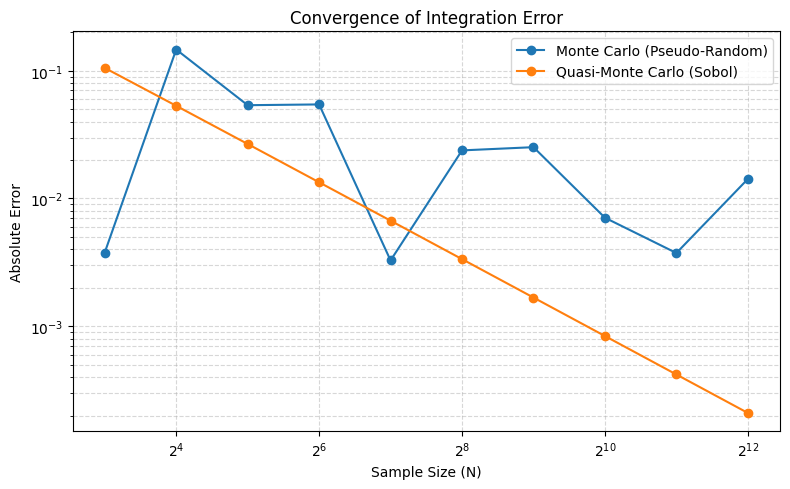

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, mc_errors, label="Monte Carlo (Pseudo-Random)", marker='o')
plt.plot(sample_sizes, qmc_errors, label="Quasi-Monte Carlo (Sobol)", marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)

plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Sample Size (N)")
plt.ylabel("Absolute Error")
plt.title("Convergence of Integration Error")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("integration_convergence.png", dpi=300)
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm

# Black-Scholes analytical formula
def black_scholes_call(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0
true_price = black_scholes_call(S0, K, r, sigma, T)

# Sample sizes
sample_sizes = [2**i for i in range(3, 13)]  # N = 8 to 4096

mc_errors = []
qmc_errors = []

for N in sample_sizes:
    # --- Monte Carlo Simulation ---
    z_mc = np.random.randn(N)
    ST_mc = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z_mc)
    payoff_mc = np.maximum(ST_mc - K, 0)
    mc_price = np.exp(-r * T) * np.mean(payoff_mc)
    mc_errors.append(abs(mc_price - true_price))

    # --- Quasi-Monte Carlo (Sobol + inverse transform) ---
    sobol_engine = qmc.Sobol(d=1, scramble=False)
    u_qmc = sobol_engine.random_base2(m=int(np.log2(N))).flatten()
    z_qmc = norm.ppf(u_qmc)
    ST_qmc = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z_qmc)
    payoff_qmc = np.maximum(ST_qmc - K, 0)
    qmc_price = np.exp(-r * T) * np.mean(payoff_qmc)
    qmc_errors.append(abs(qmc_price - true_price))


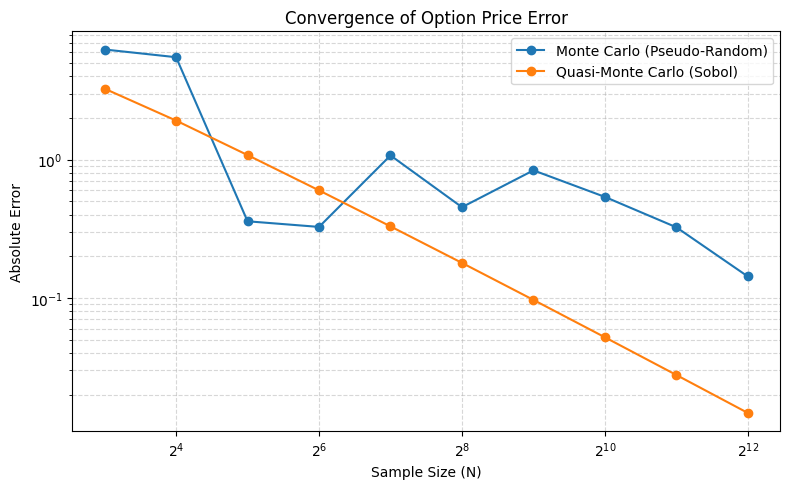

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, mc_errors, label="Monte Carlo (Pseudo-Random)", marker='o')
plt.plot(sample_sizes, qmc_errors, label="Quasi-Monte Carlo (Sobol)", marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)

plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Sample Size (N)")
plt.ylabel("Absolute Error")
plt.title("Convergence of Option Price Error")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("option_convergence.png", dpi=300)
plt.show()


In [ ]:
np.random.seed(42)

mc_estimates = []
qmc_estimates = []

print(f"{'N':>6} | {'MC Estimate':>12} | {'QMC Estimate':>12} | {'MC Error':>10} | {'QMC Error':>10}")
print("-" * 65)

for N in sample_sizes:
    # Monte Carlo
    z_mc = np.random.randn(N)
    ST_mc = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z_mc)
    payoff_mc = np.maximum(ST_mc - K, 0)
    mc_price = np.exp(-r * T) * np.mean(payoff_mc)
    mc_error = abs(mc_price - true_price)
    mc_estimates.append(mc_price)
    mc_errors.append(mc_error)

    # QMC
    sobol_engine = qmc.Sobol(d=1, scramble=False)
    u_qmc = sobol_engine.random_base2(m=int(np.log2(N))).flatten()
    z_qmc = norm.ppf(u_qmc)
    ST_qmc = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z_qmc)
    payoff_qmc = np.maximum(ST_qmc - K, 0)
    qmc_price = np.exp(-r * T) * np.mean(payoff_qmc)
    qmc_error = abs(qmc_price - true_price)
    qmc_estimates.append(qmc_price)
    qmc_errors.append(qmc_error)

    print(f"{N:6} | {mc_price:12.6f} | {qmc_price:12.6f} | {mc_error:10.6f} | {qmc_error:10.6f}")


     N |  MC Estimate | QMC Estimate |   MC Error |  QMC Error
-----------------------------------------------------------------
     8 |    15.759109 |     7.193778 |   5.308526 |   3.256806
    16 |     4.478611 |     8.535366 |   5.971972 |   1.915217
    32 |     7.318500 |     9.371661 |   3.132083 |   1.078923
    64 |     9.199831 |     9.851199 |   1.250752 |   0.599385
   128 |    11.307071 |    10.121304 |   0.856487 |   0.329279
   256 |    10.963701 |    10.271297 |   0.513117 |   0.179286
   512 |    10.818211 |    10.353739 |   0.367627 |   0.096844
  1024 |    11.095092 |    10.398592 |   0.644509 |   0.051992
  2048 |    10.402089 |    10.422822 |   0.048494 |   0.027762
  4096 |    10.279884 |    10.435825 |   0.170700 |   0.014758
